In [1]:
import pandas as pd
from pathlib import Path

In [2]:
def extract_information(file_path):
    """
    Extracts the implementation type (CPU or GPU), the argument value from the filename,
    and the execution time from the content of the file.
    """
    # Extract implementation and number of docs from filename
    parts = file_path.stem.split('-')  # split the stem part of the filename
    implementation = parts[1].upper()  # Get 'GPU' or 'CPU' and make it uppercase
    _, implementation, iteration, n_docs, n_queries = parts
    
    # Read execution time from file
    execution_time = None
    with file_path.open('r') as file:
        for line in file:
            if "Elapsed time:" in line:
                execution_time = float(line.split()[-2])  # Get the last second to last part assuming "Elapsed time: X ms"
                break
    assert execution_time is not None, "Failed to parse execution time."
    return dict(implementation=implementation.upper(), n_docs=n_docs, n_queries=n_queries, execution_time=execution_time, iteration=iteration)

In [3]:
# Collect all txt files matching the pattern
files = Path('../results/').glob('out-*.txt')

# Extract information from each file and create a DataFrame
data = [extract_information(file) for file in files]
df = pd.DataFrame.from_records(data)

print(df)

UnboundLocalError: local variable 'execution_time' referenced before assignment

In [ ]:
df.sort_values(by=['implementation', 'n_docs'])

,implementation,n_docs,execution_time,iteration
11,CPU,10,0.922,3
17,CPU,10,0.554,4
24,CPU,10,1.304,1
35,CPU,10,1.344,2
38,CPU,10,0.923,5
0,CPU,100,9.341,3
20,CPU,100,9.310,2
34,CPU,100,9.358,4
36,CPU,100,9.357,1
37,CPU,100,10.101,5


In [ ]:
agg_df = (
    df[['implementation', 'n_docs', 'execution_time']]
        .groupby(['implementation', 'n_docs'])
        .agg(['mean', 'min', 'max', 'std'])
        .reset_index()
)
agg_df.columns = [f'{col[1]}_{col[0]}' if col[0] == 'execution_time' else col[0] for col in agg_df.columns]
agg_df.head()

,implementation,n_docs,mean_execution_time,min_execution_time,max_execution_time,std_execution_time
0,CPU,10,1.0094,0.554,1.344,0.324515
1,CPU,100,9.4934,9.310,10.101,0.340212
2,CPU,1000,64.4666,63.691,65.228,0.619466
3,CPU,10000,553.6192,544.190,557.631,5.413971
4,GPU,10,227.3144,225.846,228.892,1.204856


In [ ]:
cpu_df = agg_df[agg_df['implementation']=='CPU'].copy()
gpu_df = agg_df[agg_df['implementation']=='GPU'].copy()

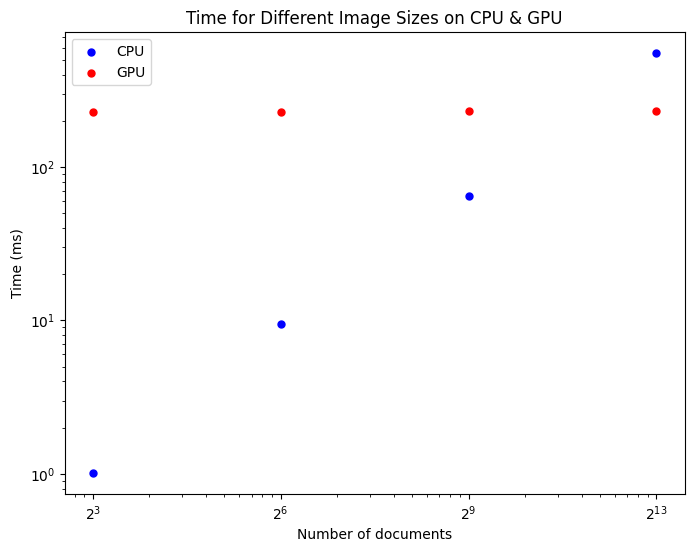

In [ ]:
import math
import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(cpu_df['n_docs'], cpu_df['mean_execution_time'], label='CPU', marker='.', s=100, c='blue')

ax.scatter(gpu_df['n_docs'], gpu_df['mean_execution_time'], label="GPU", marker='.', s=100, c='red')

ax.set_title('Time for Different Image Sizes on CPU & GPU')
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Number of documents')
ax.set_xscale("log")
ax.set_yscale("log")
plt.xticks(cpu_df['n_docs'], labels=[f"$2^{{{int(math.log(n_inp_element, 2))}}}$" for n_inp_element in cpu_df['n_docs'].values])
ax.legend()

plt.show()